# Predicting Hotel Cancellations

### In this analysis, I will be exploring a hotel cancellation dataset aimed to increase revenue from their room bookings.
#### Unsupervised learning to gain insights.
- By clustering the data, I will be identifying distinct cancellation patterns that inform subsequent analysis.
- Using these insights, I will be cleaning missing values, perform feature engineering, and change data types, allowing me to retain approximately 94% of the data.

#### Then I will use supervised learning with a random forest algorithm to achieve around ~91% precision and ~93% recall and obtain feature importances

- These feature importances reveal that lead time is the most significant factor in predicting cancellations.

- And while searching for answers to question of the hotel: `Are cancellations more likely during weekends?`, will be finding out that the duration of stay also playing a role on the cancellations.

- Additionally, I ll be having a quick look at potential seasonality in cancellation patterns.

- Overall, this analysis might provide valuable insights into hotel cancellations and can aid in developing strategies to mitigate cancellations in the future.

![hotel cancellation banner](https://digital.ihg.com/is/image/ihg/crowneplaza-homepage-hero-lvp-1440x617)

##### <div style="text-align:right;">Image Source: IHG Hotels&Resorts </div>

 #### At the conclusion of this notebook, you will find my discoveries, recommendations, and potential next actions.

## Let's start exploring.

In [3]:
import pandas as pd

hotels = pd.read_csv("data/hotel_bookings.csv")

In [4]:
hotels.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,INN00002,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018.0,11.0,6.0,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,INN00003,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018.0,2.0,28.0,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,INN00004,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018.0,5.0,20.0,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,INN00005,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018.0,4.0,11.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled


In [5]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          35862 non-null  float64
 2   no_of_children                        35951 non-null  float64
 3   no_of_weekend_nights                  35908 non-null  float64
 4   no_of_week_nights                     35468 non-null  float64
 5   type_of_meal_plan                     35749 non-null  object 
 6   required_car_parking_space            33683 non-null  float64
 7   room_type_reserved                    35104 non-null  object 
 8   lead_time                             35803 non-null  float64
 9   arrival_year                          35897 non-null  float64
 10  arrival_month                         35771 non-null  float64
 11  arrival_date   

In [6]:
hotels.shape

(36275, 19)

#### Just having a quick look at the first column, want to see if the bookings without adults have been cancelled more often.

In [7]:
no_adults = hotels[(hotels.no_of_adults == 0) & (hotels.no_of_children != 0) & (~hotels.no_of_children.isna())]
val_no_adult = no_adults.booking_status.value_counts()
print(f"Bookings with no adult = {(val_no_adult[1]/(val_no_adult.sum())*100):.2f} % Canceled.")

val_all = hotels.booking_status.value_counts()
print(f"Bookings in general = {(val_all[1]/(val_all.sum())*100):.2f} % Canceled.\n")

print("Bookings with no adult: \n", val_no_adult,'\n\n',"Bookings in general:\n", val_all)

Bookings with no adult = 31.11 % Canceled.
Bookings in general = 32.76 % Canceled.

Bookings with no adult: 
 Not_Canceled    93
Canceled        42
Name: booking_status, dtype: int64 

 Bookings in general:
 Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64


#### Doesn't seem to be the case and there are too few entries. Let's have a quick look at market segment type.

In [8]:
grouped = hotels.groupby("booking_status").market_segment_type.value_counts()
grouped

booking_status  market_segment_type
Canceled        Online                  8145
                Offline                 3023
                Corporate                204
                Aviation                  36
Not_Canceled    Online                 14119
                Offline                 7053
                Corporate               1722
                Complementary            375
                Aviation                  86
Name: market_segment_type, dtype: int64

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
sns.set_palette("pastel")
%matplotlib inline

<AxesSubplot: xlabel='market_segment_type', ylabel='count'>

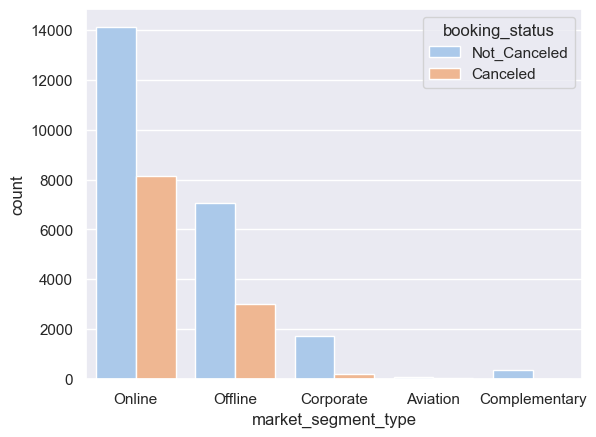

In [10]:
sns.countplot(data=hotels, x="market_segment_type", hue="booking_status")

#### I will use unsupervised learning for exploration. But let's first handle the missing values. Remember we have 12929 missing values. But hopefully the columns have common missing entries so wo don't lose too much data. 

In [11]:
data = hotels.copy()
data = data.dropna()
f"Would be dropping {((hotels.shape[0] - data.shape[0]) / hotels.shape[0])*100:.2f} % of data"

'Would be dropping 24.16 % of data'

That s too much of a loss, but i think i can still use unsupervised learning for exploratory reasons to learn more about my data and also with those insights will be able to impute the missing values better hopefully.

## Unsupervised learning
Will be using dimension reduction and K-Means clustering.
#### Goal : Getting insights about the data to be able to replace some of the missing values.

### Preprocessing

I will be getting dummies for categorical values.

In [12]:
categorical = ["type_of_meal_plan", "room_type_reserved", "market_segment_type", "arrival_year", "arrival_month", "required_car_parking_space", "repeated_guest",]

In [13]:
data = data.drop(["Booking_ID","booking_status", "arrival_date"], axis=1)
temp = data.copy()

- data will be used to visualize the clusters we find later on.
- temp will be used to get dummies and explore further.

In [14]:
from sklearn.preprocessing import StandardScaler

temp = pd.get_dummies(temp, columns=categorical, drop_first=True)

scaler = StandardScaler()
scaled_temp = scaler.fit_transform(temp)

In [15]:
temp.shape, scaled_temp.shape

((27511, 36), (27511, 36))

### KMeans clustering - How many neighbors? 

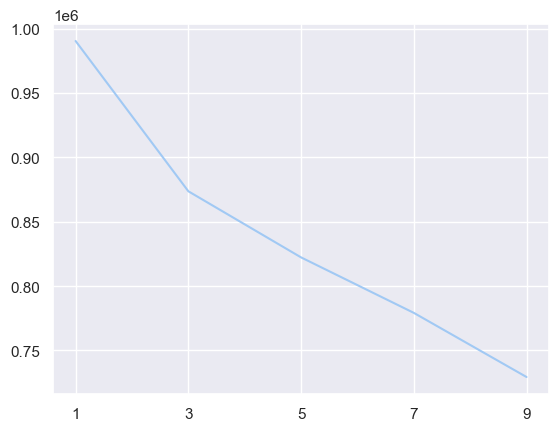

In [16]:
from sklearn.cluster import KMeans
inertia = []

for k in range(1,10,2):
    model = KMeans(n_clusters=k, n_init=1, random_state=42)
    model.fit(scaled_temp)
    inertia.append(model.inertia_)

fig, ax = plt.subplots()
ax.plot(range(1,10,2), inertia)
ax.set_xticks(range(1,10,2))
plt.show()

"elbow" seems to be at n_clusters=3

#### While at it, would be nice to see explained variance of our features for possible dimension reduction for clustering.

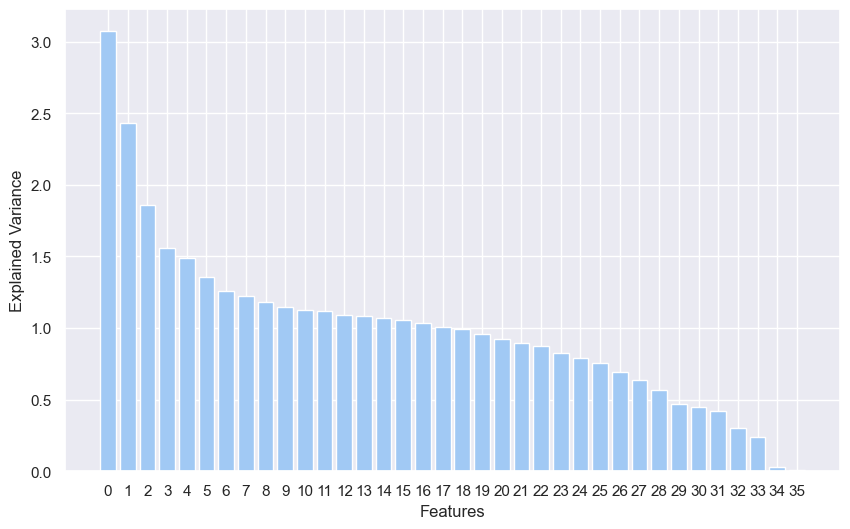

In [17]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_temp)
features = range(pca.n_components_)

plt.figure(figsize=(10, 6))
plt.bar(features, pca.explained_variance_ )
plt.xticks(range(0,36))
plt.xlabel("Features")
plt.ylabel("Explained Variance")
plt.show()

### Explained variance per dimension may not be enough to decide. Let's check total explained variance instead.

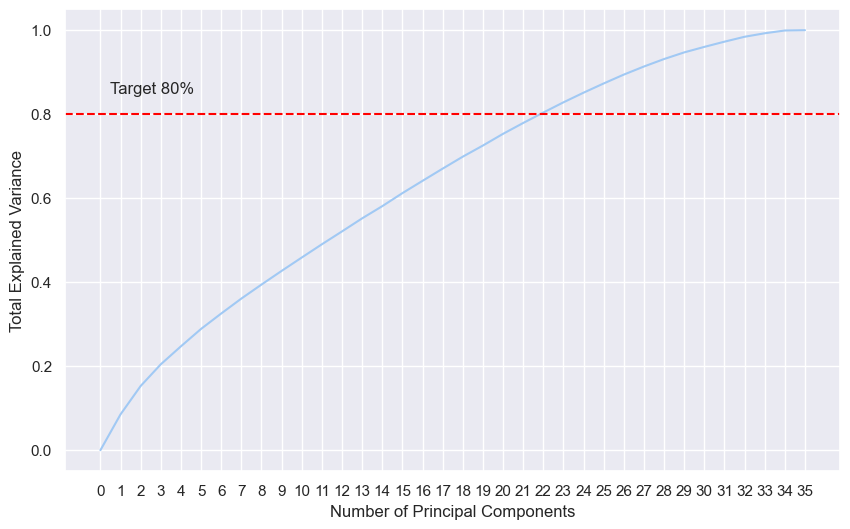

In [18]:
n_components = list(range(36))
explained_variance = []

for i in n_components:
    pca = PCA(n_components=i)
    pca.fit(scaled_temp)
    exp_var = pca.explained_variance_ratio_
    explained_variance.append(exp_var.sum())

plt.figure(figsize=(10, 6))
plt.plot(n_components, explained_variance)
plt.xlabel("Number of Principal Components")
plt.xticks(range(36))
plt.ylabel("Total Explained Variance")

plt.axhline(y=0.8, color='red', linestyle='--')
plt.annotate("Target 80%", xy=(0.5, 0.8), xytext=(0.5, 0.8+0.05))
plt.show()

#### It lookslike it will be possible to reduce the dimensions while retaining ~80 of the information but is it necesarry?
80-20 sounds good but dropping from 36 to 22 dimensions may not be that interesting. Considering it doesn't necessarily mean that we are choosing 22 specific features from the original 36 with PCA. Instead we would be choosing a combination of all 36 features that best represents the data and explains most of its variance. 
- (Also checked this before getting dummies and in that case we are dropping from 16 to 10 features to get 80% total explained variance.)

##### For plotting will be using 'data' as dataframe but the cluster column info is still coming from scaled_temp

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data["type_of_meal_plan"] = le.fit_transform(data["type_of_meal_plan"])
data["room_type_reserved"] = le.fit_transform(data["room_type_reserved"])
data["market_segment_type"] = le.fit_transform(data["market_segment_type"])
data["booking_status"] = hotels.dropna().booking_status.copy()

### So let s check the 3 cluster results with KMeans clustering without dimension reduction.

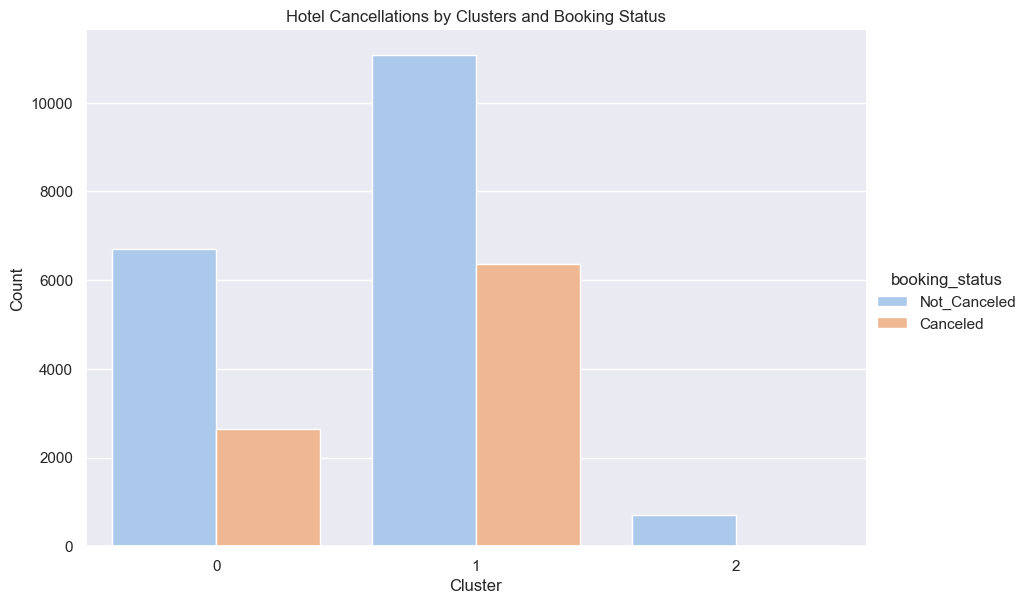

In [20]:
kmeans = KMeans(n_clusters=3, n_init=1, random_state=42)
clusters = kmeans.fit_predict(scaled_temp)
data["cluster"] = clusters

sns.catplot(x="cluster", hue="booking_status", data=data, kind="count", height=6, aspect=1.5)

plt.title("Hotel Cancellations by Clusters and Booking Status")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

### Plotting `some` of the features with cluster differences and `some` without to get insights before our next step.

In [21]:
not_much_diff = data[['no_of_adults', 'arrival_month', 'market_segment_type','cluster','booking_status']]
diff = data[['no_of_previous_bookings_not_canceled', 'no_of_previous_cancellations', 
                 'repeated_guest', 'cluster','booking_status']]

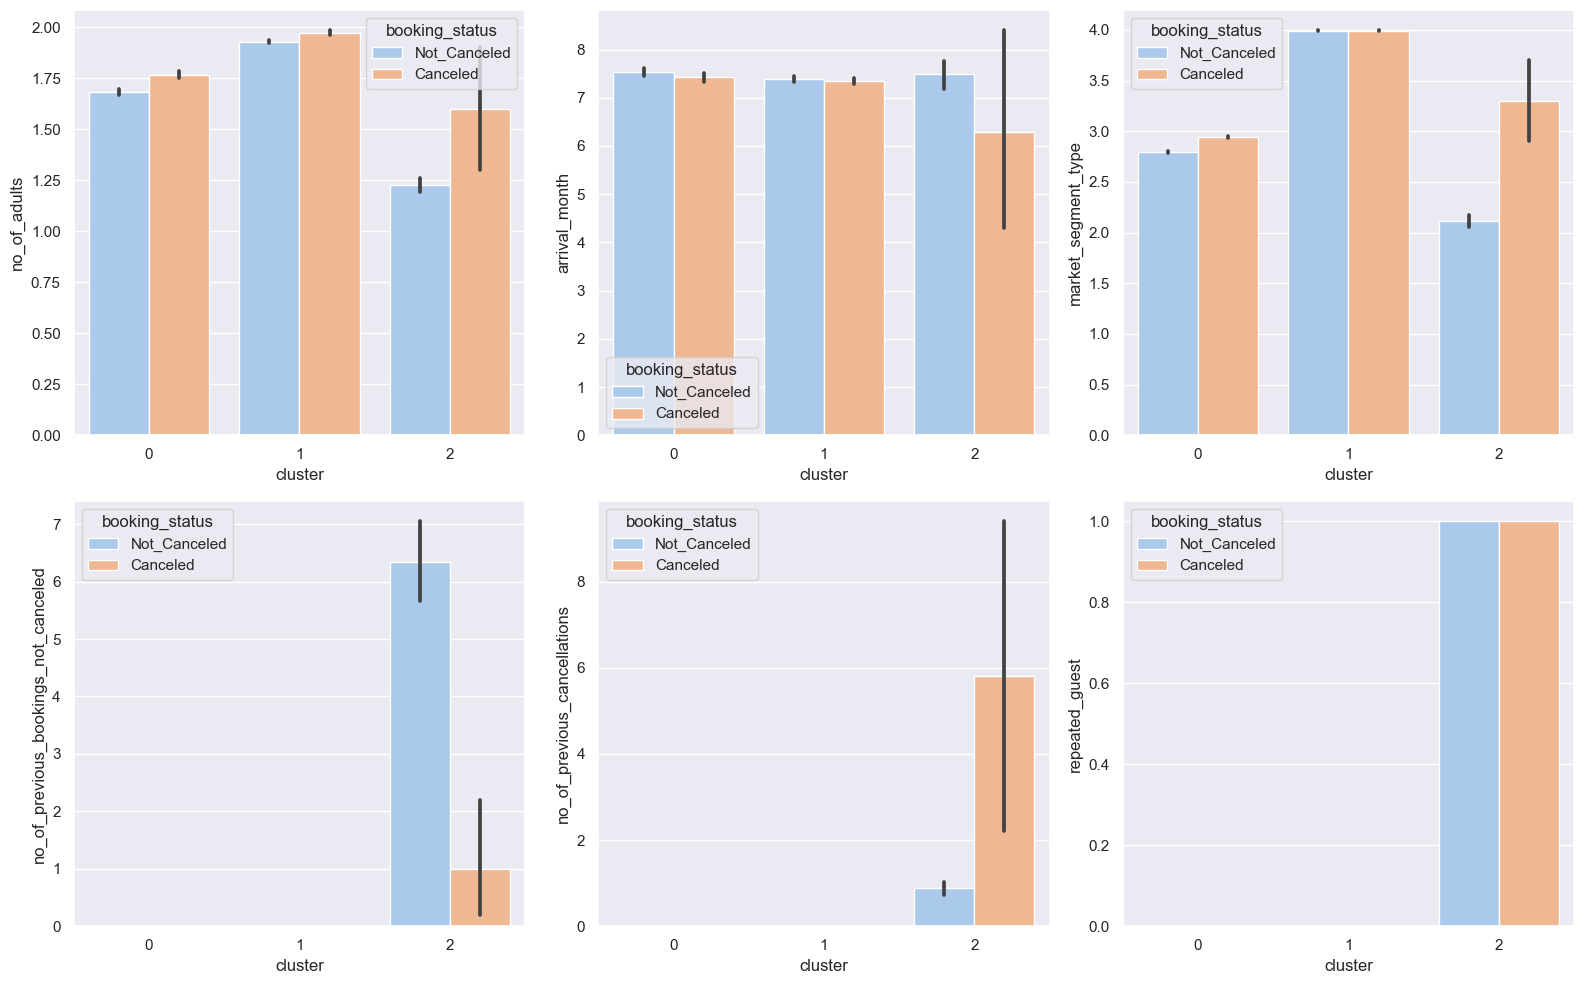

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(16,10))

for i, column in enumerate(not_much_diff.columns[0:-2]):
    sns.barplot(data=not_much_diff, x="cluster", y=column, hue='booking_status', ax=axes[0, i])

for i, column in enumerate(diff.columns[0:-2]):
    sns.barplot(data=diff, x="cluster", y=column, hue='booking_status', ax=axes[1, i])

plt.tight_layout()
plt.show()

### The features on the bottom row have interesting clustering as we can see above, when we check these features on our original data we can see that booking status have some pattern so while imputing missing values have to be extra careful with decision making on these features.
- 'no_of_previous_bookings_not_canceled'
- 'no_of_previous_cancellations' 
- 'repeated_guest'

##### Note that some of the features are also more skewed than others so keeping that also in mind...

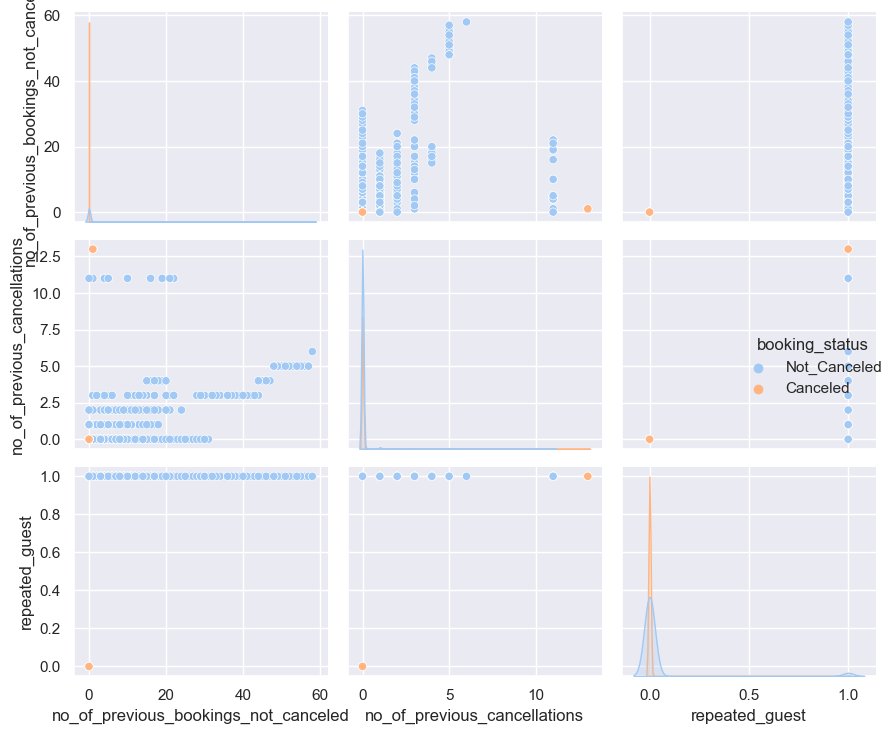

In [23]:
# some of the features with clustering differences
diff_features = ["no_of_previous_bookings_not_canceled", "no_of_previous_cancellations", "repeated_guest", "booking_status"]
sns.pairplot(data = data[diff_features], hue = "booking_status")
plt.tight_layout()
plt.show()

#### Expected that customers are cancelling less if they have earlier bookings which are not cancelled.

In [24]:
data[data["no_of_previous_bookings_not_canceled"] > 0 ].booking_status.value_counts()

Not_Canceled    621
Canceled          5
Name: booking_status, dtype: int64

#### Did not expect that customers with previous cancellations to cancel also less compared to rest of the data.

In [25]:
data[data["no_of_previous_cancellations"] > 0 ].booking_status.value_counts()

Not_Canceled    258
Canceled         10
Name: booking_status, dtype: int64

#### Expected that repeated guests cancel rarely compared to rest of the data

In [26]:
data[data["repeated_guest"] > 0 ].booking_status.value_counts()

Not_Canceled    710
Canceled         10
Name: booking_status, dtype: int64

Original data booking status as reference:

In [27]:
h = hotels.booking_status.value_counts()
print(f"{h[1] / (h[0] + h[1])*100:.2f} % of customers cancel their bookings.\n")
print(h)

32.76 % of customers cancel their bookings.

Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64


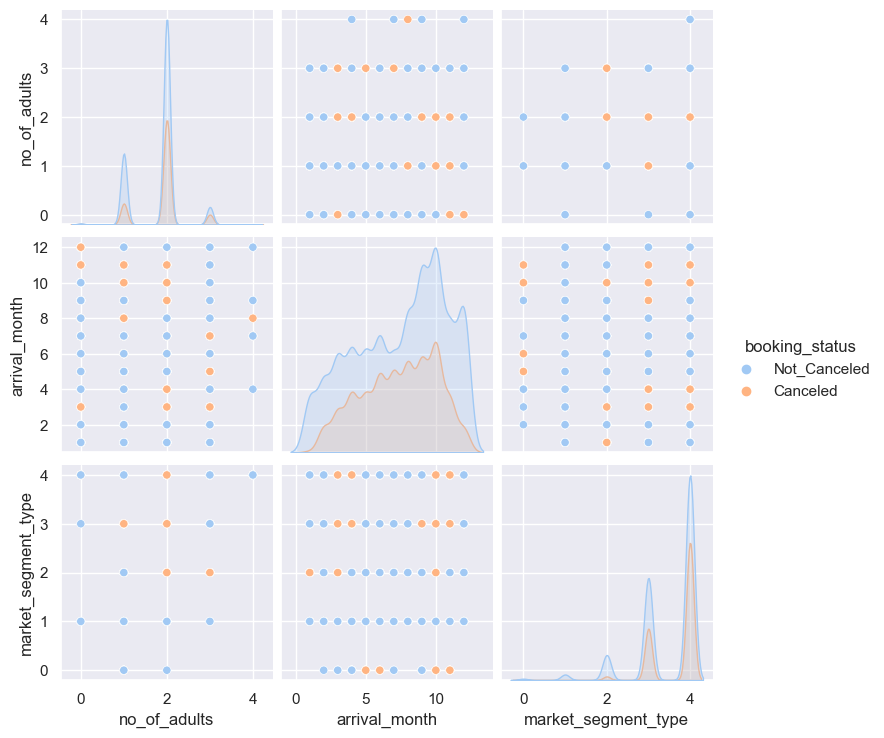

In [28]:
# some of the features from clustering results without a special pattern on the booking status.
not_much_diff_features = ["no_of_adults", "arrival_month", "market_segment_type", "booking_status"]
sns.pairplot(data = data[not_much_diff_features], hue = "booking_status")
plt.show()

#### As we can see above, booking status has not a visible pattern on these features. So i will be able to fill some of missing values on these columns more freely(mean,mode,median) compared to our features some visible clustering to preserve more data before our next step.

So we gained some insights about our data with unsupervised learning we can continiue and prepare the data for supervised learning. 

##### Still have to check for weekend and weekdays, arrival_year/month/date

### Checkpoint I

In [29]:
df = hotels.copy()

## Preparing the data (for Supervised Learning)

### Missing values

In [30]:
display("Total missing values: " + str(df.isna().sum().sum()))

'Total missing values: 12929'

#### Will check one column at a time and make decisions depending on the skewness and statistics of the column.

- `no_of_adults`   The number of adults.

In [31]:
df.no_of_adults.describe()

count    35862.000000
mean         1.845017
std          0.518652
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: no_of_adults, dtype: float64

It can be counted as not a valid booking if number of adults and number of children are both 0. 
So we can fill the missing values with median value where values are missing or 0 on both columns for the adults.

In [32]:
import numpy as np

df["no_of_adults"] = np.where(
    ((df["no_of_children"].isnull()) | (df["no_of_children"] == 0)) & 
    ((df["no_of_adults"].isnull()) | (df["no_of_adults"] == 0)), 2, df["no_of_adults"])

df.no_of_adults.isna().sum()

23

- `no_of_children`   The number of children.

In [33]:
df.no_of_children.value_counts()

0.0     33275
1.0      1605
2.0      1049
3.0        19
9.0         2
10.0        1
Name: no_of_children, dtype: int64

Might be a good idea to replace missing 324 values with 0 and will be converting this column to boolean when changing/controlling dtypes. 
- with_children : True, False

In [34]:
df["no_of_children"] = df["no_of_children"].fillna(0)

Will be exploring possible seasonal differences after the supervised learning. Will get dummies for month and year as categorical values for our model(s) for now.

- `arrival_year`  Year of arrival.
- `arrival_month` Month of arrival. 
- `arrival_date`  Date of the month for arrival. 

In [35]:
import numpy as np

# might aswel remove the day column later but for now filling with median value
display(df.arrival_date.isna().sum())
display(df.arrival_date.describe())
df["arrival_date"] = np.where(df["arrival_date"].isnull(), 16, df["arrival_date"])

# depending on the future importances we might try another way of imputing but for now will be filling with median aswel
display(df["arrival_month"].isna().sum())
display(df.arrival_month.describe())
df["arrival_month"] = np.where(df["arrival_month"].isnull(), 8 , df["arrival_month"])

# display(df[df.arrival_year == 2017]) - > last entry from 2017 is index 5882
display(df.iloc[:, 9:10].value_counts())
df["arrival_year"] = df.arrival_year.fillna(2018)

981

count    35294.000000
mean        15.605712
std          8.743484
min          1.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         31.000000
Name: arrival_date, dtype: float64

504

count    35771.000000
mean         7.424031
std          3.068277
min          1.000000
25%          5.000000
50%          8.000000
75%         10.000000
max         12.000000
Name: arrival_month, dtype: float64

arrival_year
2018.0          29451
2017.0           6446
dtype: int64

- `required_car_parking_space` Whether a car parking space is required.

In [36]:
display(df.required_car_parking_space.value_counts())

# replacing na with 0
df["required_car_parking_space"] = df["required_car_parking_space"].fillna(0)

0.0    32649
1.0     1034
Name: required_car_parking_space, dtype: int64

- `room_type_reserved`  The type of room reserved. 

Room_Type 1    28405
Room_Type 4     5851
Room_Type 6      939
Room_Type 2      664
Room_Type 5      256
Room_Type 7      154
Room_Type 3        6
Name: room_type_reserved, dtype: int64

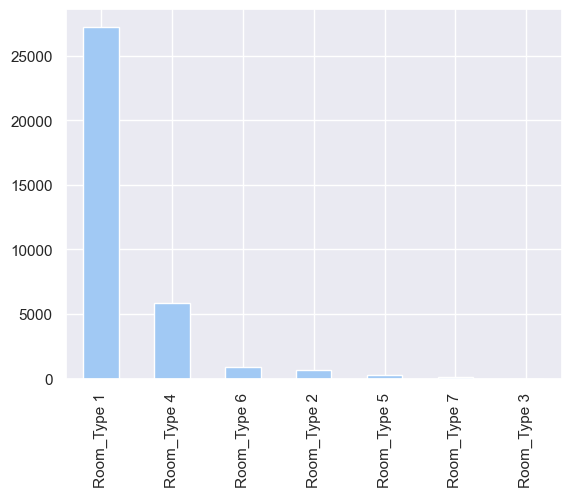

In [37]:
df.room_type_reserved.value_counts().plot(kind="bar")

# will assign Room_Type 1 for the missing values
df["room_type_reserved"] = np.where(df["room_type_reserved"].isnull(), "Room_Type 1", df["room_type_reserved"])
df.room_type_reserved.value_counts()

- `market_segment_type`   How the booking was made.

In [38]:
df.market_segment_type.value_counts()

# Seems safe to assign 'Online' for 1512 missing values
df["market_segment_type"] = np.where(df["market_segment_type"].isnull(), "Online", df["market_segment_type"])
df.market_segment_type.value_counts()

Online           23776
Offline          10076
Corporate         1926
Complementary      375
Aviation           122
Name: market_segment_type, dtype: int64

- `no_of_special_requests`    Count of special requests made as part of the booking

<AxesSubplot: >

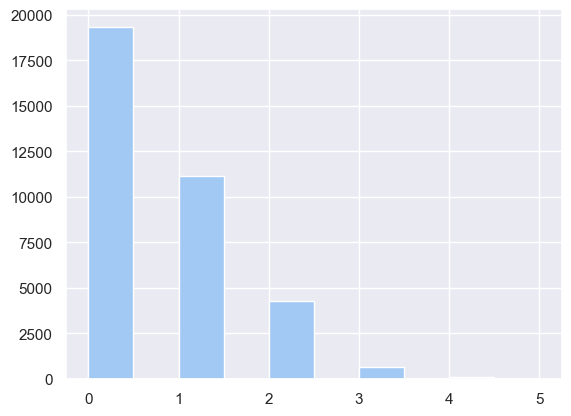

In [39]:
df.no_of_special_requests.hist()
# null values on this column can be replaced with 0

In [40]:
df["no_of_special_requests"] = df["no_of_special_requests"].fillna(0)
df.no_of_special_requests.value_counts()


0.0    20139
1.0    11125
2.0     4273
3.0      653
4.0       77
5.0        8
Name: no_of_special_requests, dtype: int64

- `no_of_weekend_nights`    Number of weekend nights (Saturday or Sunday). 
- `no_of_week_nights`   Number of week nights (Monday to Friday).

It doesnt make much sense to have both weekend and week nights NaN or 0. Even if the booking is cancelled, the info should have remained.

In [41]:
mask = (((df['no_of_weekend_nights'].isna()) | (df['no_of_weekend_nights'] == 0)) & 
       ((df["no_of_week_nights"].isna()) | (df["no_of_week_nights"] == 0)))
df[mask].booking_status.value_counts()

Not_Canceled    386
Canceled        126
Name: booking_status, dtype: int64

In [42]:
# Will fill median values where both weekend and week nights are missing or 0 in the same row at the same time.

df['no_of_week_nights'] = np.where(mask, df['no_of_week_nights'].median(), df['no_of_week_nights'])
df['no_of_weekend_nights'] = np.where(mask, df['no_of_weekend_nights'].median(), df['no_of_weekend_nights'])

- `type_of_meal_plan`   Type of meal plan included in the booking.

In [43]:
df.type_of_meal_plan.value_counts()

# That's handy there is already an option for not selecting meal plan for the missing values.
df["type_of_meal_plan"] = df["type_of_meal_plan"].fillna("Not Selected")

- `avg_price_per_room`  Average price per day of the booking.

In [44]:
df.avg_price_per_room.describe() # mean and median are close ~100

count    35815.000000
mean       103.418207
std         35.057342
min          0.000000
25%         80.300000
50%         99.450000
75%        120.000000
max        540.000000
Name: avg_price_per_room, dtype: float64

In [45]:
df["avg_price_per_room"] = df.avg_price_per_room.fillna(100.00)

- `lead_time` Number of days before the arrival date the booking was made.

There are 28 days difference between mean and 50% percentile. This feature might be too sensitive to impute.

count    35803.000000
mean        85.276569
std         85.998845
min          0.000000
25%         17.000000
50%         57.000000
75%        126.000000
max        443.000000
Name: lead_time, dtype: float64

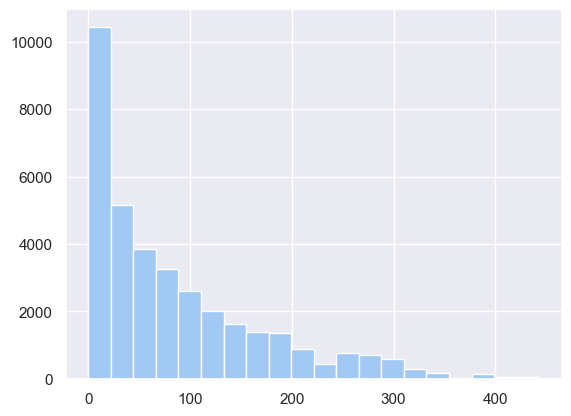

In [46]:
df.lead_time.hist(bins=20)
df.lead_time.describe()

- `repeated_guest` Whether the guest has previously stayed at the hotel.

In [47]:
display(df.repeated_guest.value_counts())
df["repeated_guest"] = df.repeated_guest.fillna(0.0)

0.0    34773
1.0      916
Name: repeated_guest, dtype: int64

- `no_of_previous_cancellations`  Number of previous cancellations. 
- `no_of_previous_bookings_not_canceled` Number of previous bookings that were `not` canceled. 


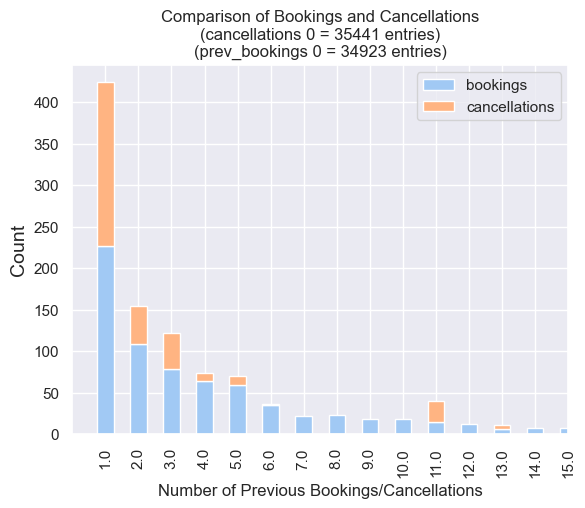

In [48]:
bookings = df[df["no_of_previous_bookings_not_canceled"] != 0]["no_of_previous_bookings_not_canceled"].value_counts()
cancellations = df[df["no_of_previous_cancellations"] != 0]["no_of_previous_cancellations"].value_counts()

df_stacked = pd.DataFrame({"bookings": bookings, "cancellations": cancellations})
df_stacked.plot(kind="bar", stacked=True)

plt.xlabel("Number of Previous Bookings/Cancellations")
plt.ylabel("Count", fontsize = 14,)
plt.title("Comparison of Bookings and Cancellations\n(cancellations 0 = 35441 entries)\n(prev_bookings 0 = 34923 entries)")
plt.xlim(-1,14)
plt.xticks(range(0,15))
plt.show()


These 2 features are also too sensitive to replace missing values.

In [49]:
print(f"Missing values before cleaning : {hotels.isna().sum().sum()}\n\
Missing values after cleaning : {df.isna().sum().sum()}")

Missing values before cleaning : 12929
Missing values after cleaning : 2205


### Checkpoint II

In [50]:
# Will be dropping remaining missing values

data_clean = df.copy()
data_clean = data_clean.dropna()
f"Will be dropping {(df.shape[0]-data_clean.shape[0]) / df.shape[0]*100.:2f} % of the data"

'Will be dropping 5.337009 % of the data'

## Converting dtypes

In [51]:
data_clean.dtypes

Booking_ID                               object
no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
type_of_meal_plan                        object
required_car_parking_space              float64
room_type_reserved                       object
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
market_segment_type                      object
repeated_guest                          float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
booking_status                           object
dtype: object

In [52]:
data_clean["room_type_reserved"] = data_clean.room_type_reserved.astype('category')
data_clean["market_segment_type"] = data_clean.market_segment_type.astype('category')
data_clean["type_of_meal_plan"] = data_clean.type_of_meal_plan.astype('category')


data_clean["required_car_parking_space"] = data_clean.required_car_parking_space.astype(bool)
data_clean["repeated_guest"] = data_clean.repeated_guest.astype(bool)
data_clean["booking_status"] = data_clean.booking_status.map({"Not_Canceled":True, "Canceled":False}).astype(bool)
data_clean["no_of_children"] = data_clean.no_of_children.astype(bool)
data_clean.rename(columns={"no_of_children":"with_children"}, inplace=True)


data_clean["no_of_special_requests"] = data_clean.no_of_special_requests.astype('int8')
data_clean["no_of_adults"] = data_clean.no_of_adults.astype('int8')  
data_clean["no_of_weekend_nights"] = data_clean.no_of_weekend_nights.astype('int8')
data_clean["no_of_week_nights"] = data_clean.no_of_week_nights.astype('int8')
data_clean["arrival_month"] = data_clean.arrival_month.astype('int8')
data_clean["arrival_date"] = data_clean.arrival_date.astype('int8')
data_clean["no_of_previous_bookings_not_canceled"] = data_clean.no_of_previous_bookings_not_canceled.astype('int8')
data_clean["no_of_previous_cancellations"] = data_clean.no_of_previous_cancellations.astype('int8')
data_clean["arrival_year"] = data_clean.arrival_year.astype('int16')
data_clean["lead_time"] = data_clean.lead_time.astype('int16')
data_clean["avg_price_per_room"] = data_clean.avg_price_per_room.astype('float32')

In [53]:
data_clean.dtypes

Booking_ID                                object
no_of_adults                                int8
with_children                               bool
no_of_weekend_nights                        int8
no_of_week_nights                           int8
type_of_meal_plan                       category
required_car_parking_space                  bool
room_type_reserved                      category
lead_time                                  int16
arrival_year                               int16
arrival_month                               int8
arrival_date                                int8
market_segment_type                     category
repeated_guest                              bool
no_of_previous_cancellations                int8
no_of_previous_bookings_not_canceled        int8
avg_price_per_room                       float32
no_of_special_requests                      int8
booking_status                              bool
dtype: object

## What factors affect whether customers cancel their booking?
#### Random Forest > Feature importances



#### Goals of supervised learning : 
- Exploring feature importances.   
- Search for a goodfit model for possible predictions.
- Prepare for a CNN with the most important features if needed.(Optional) 

### Preprocessing

Creating binary variables for bookings which include weekend nights or week nights, that is the next point on the report. And this way we might get better insights while we are already exploring for the feature importances.

In [54]:
data_clean["weekend_night"] = data_clean["no_of_weekend_nights"] > 0
data_clean["week_night"] = data_clean["no_of_week_nights"] > 0

### Checkpoint III

In [55]:
df_clean = data_clean.copy()

In [56]:
df_clean = df_clean.drop(['Booking_ID', "arrival_date"], axis=1)

- Categorical nominal: type_of_meal_plan, room_type_reserved, market_segment_type, booking_status, arrival_year, arrival_month, arrival_date,required_car_parking_space, repeated_guest
- Numeric continuous: avg_price_per_room
- Numeric discrete: no_of_adults, no_of_children, no_of_weekend_nights, no_of_week_nights, lead_time, no_of_previous_cancellations, no_of_previous_bookings_not_canceled, no_of_special_requests

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_to_normalize = ["lead_time", "no_of_previous_cancellations", "no_of_previous_bookings_not_canceled",
                     "no_of_special_requests", "no_of_week_nights", "no_of_weekend_nights", 
                     "no_of_adults", "avg_price_per_room"]

df_clean[cols_to_normalize] = scaler.fit_transform(df_clean[cols_to_normalize])


categorical = ["type_of_meal_plan", "room_type_reserved", "market_segment_type", 
               "arrival_year", "arrival_month", "required_car_parking_space",
               "repeated_guest","weekend_night", "week_night", "with_children"]

df_clean = pd.get_dummies(df_clean, columns=categorical, drop_first=True)

In [58]:
X = df_clean.drop("booking_status", axis=1)
y = df_clean["booking_status"]

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 0.8893
Precision: 0.9073
Recall: 0.9322
F1 Score: 0.9196


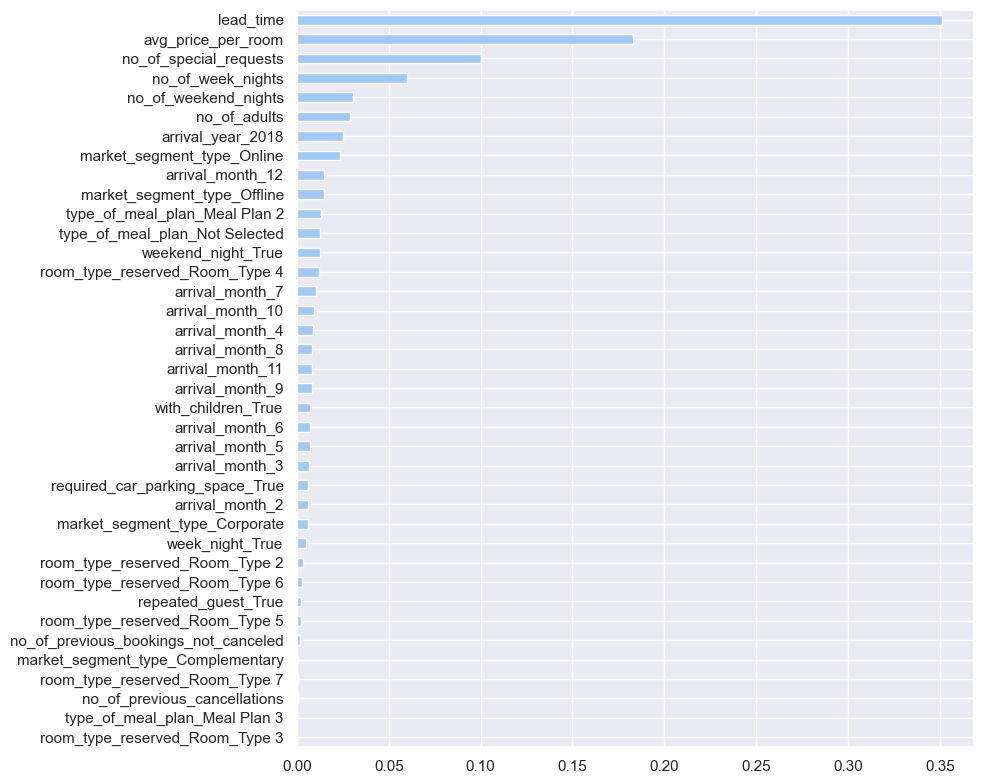

In [60]:
importances_rf = pd.Series(clf.feature_importances_, index=X.columns)
sorted_importances_rf = importances_rf.sort_values()

plt.figure(figsize=(10, 8))
sorted_importances_rf.plot(kind="barh")
plt.tight_layout()
plt.show()

- `lead_time` , `avg_price_per_room` and `no_of_special_requests` are the most important 3 features.

### lead_time `most important feature`

In [61]:
# for better visualizations
data_clean["booking_status"] = data_clean.booking_status.map({True:"Not_Canceled", False:"Canceled"})
lead_time = data_clean[["lead_time", "booking_status"]].copy()

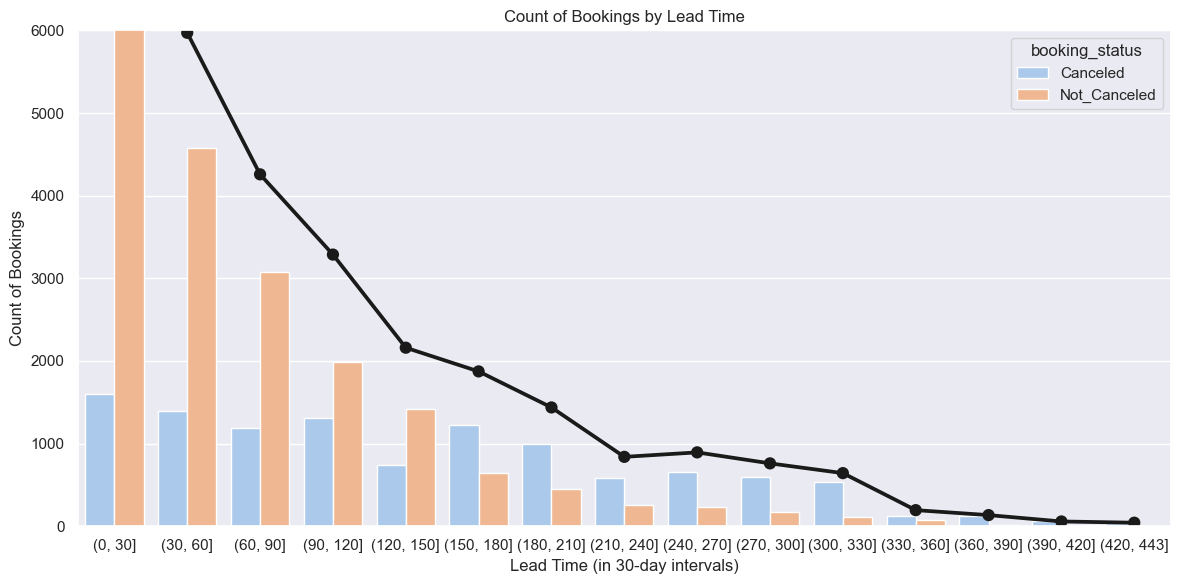

In [62]:
# 30 day intervals
bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 443]

lead_time["lead_time_bin"] = pd.cut(lead_time["lead_time"], bins=bins)
lead_time_counts = lead_time.groupby(["lead_time_bin", "booking_status"]).size().reset_index(name="count")
total_count = lead_time.groupby(["lead_time_bin"]).size().reset_index(name="total")

plt.figure(figsize=(12, 6))
sns.barplot(x="lead_time_bin", y="count", hue="booking_status", data=lead_time_counts)
sns.pointplot(x="lead_time_bin", y="total", data=total_count, color="k")

plt.title("Count of Bookings by Lead Time")
plt.xlabel("Lead Time (in 30-day intervals)")
plt.ylabel("Count of Bookings")
plt.ylim([0,6000])  # to zoom in

plt.tight_layout()
plt.show()

### The longer the lead time, the greater the likelihood of canceled bookings. Additionally, bookings made more than 150 days in advance are more frequently canceled, even though the overall number of bookings decrease.

#### Zooming out (90 days intervals)

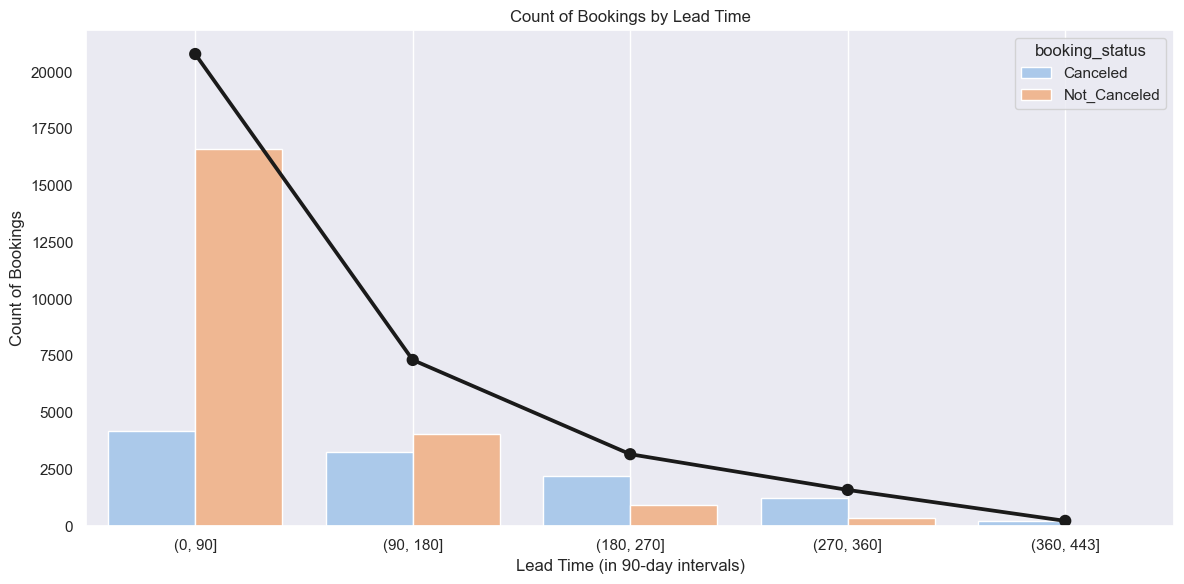

In [63]:
bins = [0, 90, 180, 270, 360, 443]

lead_time["lead_time_bin"] = pd.cut(lead_time["lead_time"], bins=bins)
lead_time_counts = lead_time.groupby(["lead_time_bin", "booking_status"]).size().reset_index(name="count")
total_count = lead_time.groupby(["lead_time_bin"]).size().reset_index(name="total")

plt.figure(figsize=(12, 6))
sns.barplot(x="lead_time_bin", y="count", hue="booking_status", data=lead_time_counts)
sns.pointplot(x="lead_time_bin", y="total", data=total_count, color="k")

plt.title("Count of Bookings by Lead Time")
plt.xlabel("Lead Time (in 90-day intervals)")
plt.ylabel("Count of Bookings")
plt.tight_layout()
plt.grid()
plt.show()

#### The rate of cancellations increase with longer lead time.
Suggestion : The hotel might offer incentives for customers who `don't` book farther in advance. 

### avg_price_per_room `2nd important feature`

In [64]:
avg_price = data_clean[["avg_price_per_room", "booking_status"]].copy()

<AxesSubplot: xlabel='booking_status', ylabel='avg_price_per_room'>

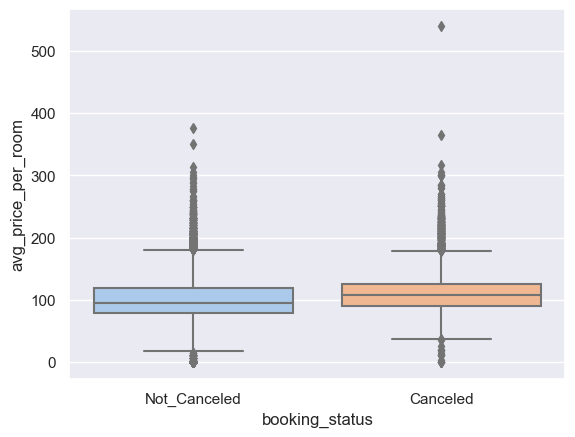

In [65]:
sns.boxplot(x="booking_status", y="avg_price_per_room", data=avg_price)

In [66]:
avg_price.avg_price_per_room.describe()

count    34339.000000
mean       103.336731
std         34.842339
min          0.000000
25%         80.750000
50%        100.000000
75%        120.000000
max        540.000000
Name: avg_price_per_room, dtype: float64

Text(59.32783593750001, 0.5, 'Booking count')

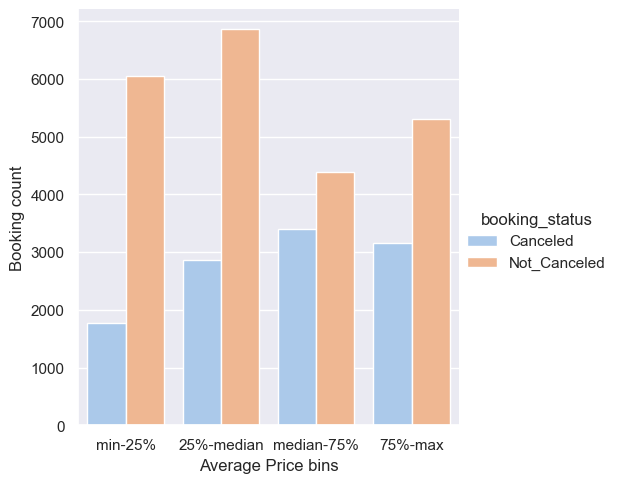

In [67]:
bins = [0, 80, 100, 120, 540,]
labels = ["min-25%", "25%-median", "median-75%", "75%-max"]

avg_price["price_bin"] = pd.cut(avg_price["avg_price_per_room"], bins=bins, labels=labels)

counts = avg_price.groupby(["price_bin", "booking_status"])["avg_price_per_room"].count().reset_index()
sns.catplot(x="price_bin", y="avg_price_per_room", hue="booking_status", data=counts, kind='bar')
plt.xlabel("Average Price bins")
plt.ylabel("Booking count")

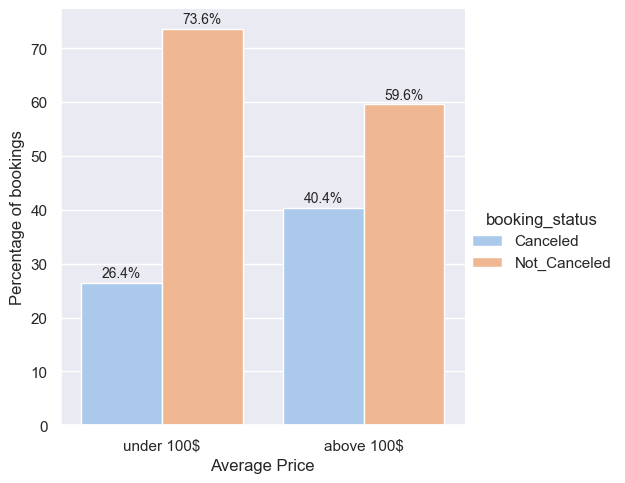

In [68]:
bins = [0, 100, 540]
labels = ["under 100$", "above 100$"]

avg_price["price_bin"] = pd.cut(avg_price["avg_price_per_room"], 
                                bins=bins, labels=labels)

counts = avg_price.groupby(["price_bin", "booking_status"])["avg_price_per_room"].count().reset_index()
total_counts = counts.groupby("price_bin")["avg_price_per_room"].sum().reset_index()

counts["percentage"] = counts.apply(lambda x: x["avg_price_per_room"] / total_counts.loc[total_counts["price_bin"] == x["price_bin"], "avg_price_per_room"].values[0], axis=1) * 100

ax = sns.catplot(x="price_bin", y="percentage", hue="booking_status", data=counts, kind='bar')
plt.xlabel("Average Price")
plt.ylabel("Percentage of bookings")

for p in ax.ax.patches:
    height = p.get_height()
    ax.ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:.1f}%'.format(height), ha="center", fontsize=10)

We already saw the negative impact of longer duration on cancellation rates. Can we say the longer stays have higher price and that s why we see this impact? 
#### Not in this case because we are using the average price per day and not total price so what we see on this plot is that the bookings above 100 dollars average day price have a higher chance to be cancelled.

### no_of_special_requests `3rd important feature`

In [69]:
sp_requests =  data_clean[["no_of_special_requests", "booking_status"]].copy()

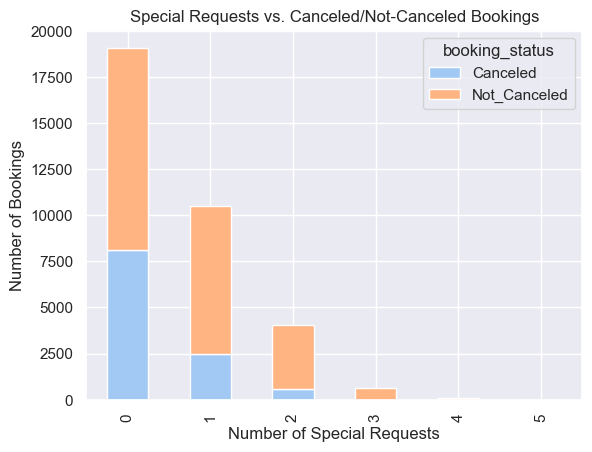

In [70]:
counts = sp_requests.groupby(["no_of_special_requests", "booking_status"]).size().unstack(fill_value=0)
ax = counts.plot.bar(stacked=True)
ax.set_xlabel("Number of Special Requests")
ax.set_ylabel("Number of Bookings")
ax.set_title("Special Requests vs. Canceled/Not-Canceled Bookings")
plt.show()

Customers with special requests tend to cancel their orders less it seems

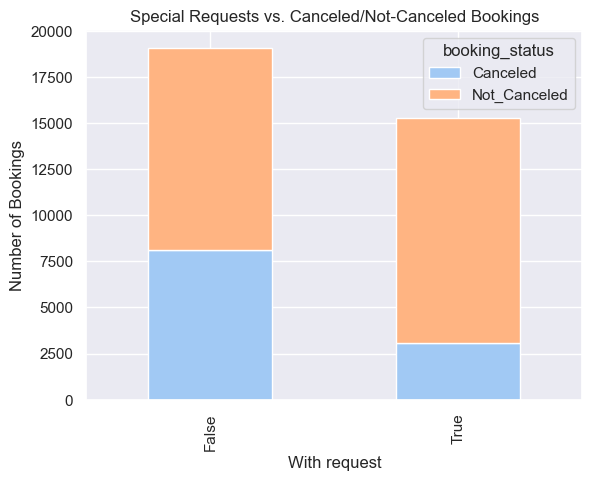

In [71]:
sp_requests["any_requests"] = sp_requests.no_of_special_requests.astype(bool)
counts = sp_requests.groupby(["any_requests", "booking_status"]).size().unstack(fill_value=0)
ax = counts.plot.bar(stacked=True)
ax.set_xlabel("With request")
ax.set_ylabel("Number of Bookings")
ax.set_title("Special Requests vs. Canceled/Not-Canceled Bookings")
plt.show()

## Are cancellations more likely during weekends?
- `no_of_weekend_nights` feature importance : 4th 
- `no_of_week_nights`    feature importance : 5th

In [72]:
weekend = data_clean.copy()

In [73]:
weekend.weekend_night.sum(), weekend.week_night.sum()

(18584, 32194)

In [74]:
weekend.booking_status.value_counts()

Not_Canceled    23129
Canceled        11210
Name: booking_status, dtype: int64

In [75]:
cancel = weekend.booking_status.value_counts()
f"{cancel[1] / (cancel[0] + cancel[1]) * 100.:3f}%"

'32.645097%'

We created True, False values on weekend_night and week_night columns using no_week_nights and no_of_weekend_nights. Just going to add `both_nights` as an extra column to extract thit information and change the values on the original columns to False. Because one booking being on a weekday or weekend at the same time doesnt give any insights other than this booking being on both weekdays and weekends, and by doing so we wont be losing information because we extract this information to new column 'both_nights'.

In [76]:
weekend["both_nights"] = weekend["weekend_night"] & weekend["week_night"]
weekend.loc[weekend["both_nights"], ["weekend_night", "week_night"]] = False

In [77]:
weekend.weekend_night.sum(), weekend.week_night.sum(), weekend.both_nights.sum()

(2145, 15755, 16439)

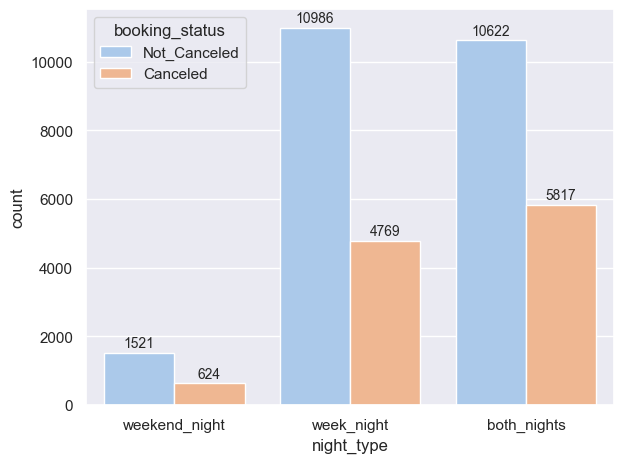

In [78]:
import seaborn as sns

to_plot = weekend[["booking_status", "weekend_night", "week_night", "both_nights"]]

data_list = []
for col in to_plot.columns[1:]:
    for val in to_plot["booking_status"].unique():
        count = to_plot[to_plot["booking_status"] == val][col].sum()
        data_list.append((val, col, count))

to_plot = pd.DataFrame(data_list, columns=["booking_status", "night_type", "count"])

ax = sns.barplot(data=to_plot, x="night_type", y="count", hue="booking_status")

for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=10, padding=2)
    
plt.tight_layout()
plt.show()

- (29%)   624 of 2145 weekend night bookings were canceled.
- (30%)   4867 of 16160 week night bookings were canceled.
- (36%)  5704 of 15993 bookings which included both week and weekend nights were canceled.

Are cancellations more likely to happen during weekends?
- Doesn't looklike it, but we can still continue exploring the relationship between duration of booking and cancellations. 

In [79]:
weekend["total_nights"] = weekend.no_of_week_nights + weekend.no_of_weekend_nights
weekend["total_nights"].describe()

count    34339.00000
mean         3.01689
std          1.76257
min          1.00000
25%          2.00000
50%          3.00000
75%          4.00000
max         24.00000
Name: total_nights, dtype: float64

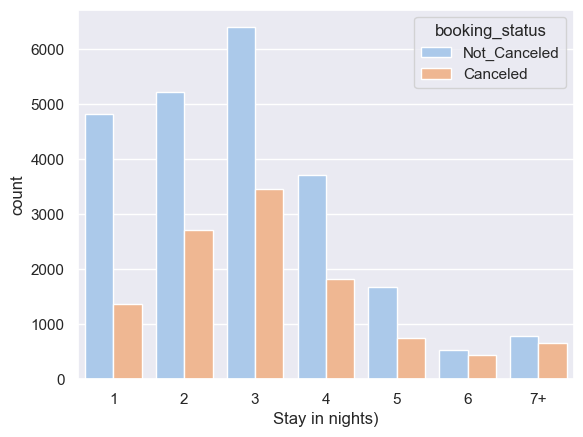

In [80]:
import numpy as np

weekend["total_nights_grouped"] = np.where(weekend["total_nights"] < 7, weekend["total_nights"], '7+')
order = [str(i) for i in range(1, 7)] + ['7+']

sns.countplot(x="total_nights_grouped", hue="booking_status", data=weekend, order=order)
plt.xlabel("Stay in nights)")
plt.show()

It lookslike cancellation rate is increasing significantly after 6 nights...

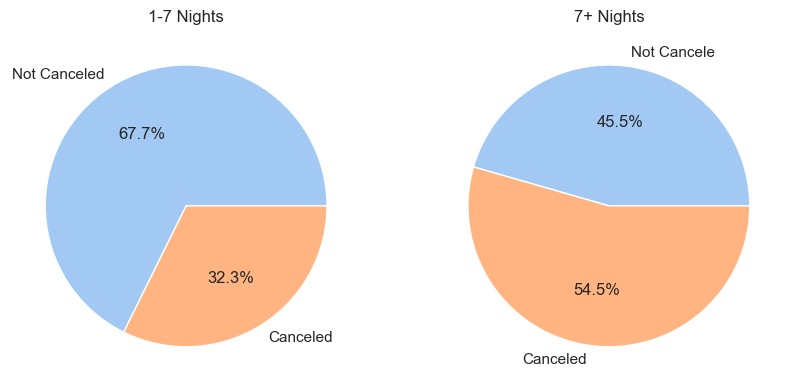

In [81]:
weekend["total_nights_cat"] = pd.cut(weekend["total_nights"], bins=[0, 7, 24], labels=["1-7 Nights", "7+ Nights"])
grouped_data = weekend.groupby(["total_nights_cat", "booking_status"]).size().reset_index(name="count")
pivot_data = grouped_data.pivot(index='total_nights_cat', columns="booking_status", values="count")
pivot_data["Cancellation Percentage"] = (pivot_data["Canceled"] / (pivot_data["Canceled"] + pivot_data["Not_Canceled"])) * 100


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pie(pivot_data.loc["1-7 Nights"][["Not_Canceled", "Canceled"]], labels=["Not Canceled", "Canceled"], autopct='%1.1f%%')
axs[0].set_title("1-7 Nights")
axs[1].pie(pivot_data.loc["7+ Nights"][["Not_Canceled", "Canceled"]], labels=["Not Cancele", "Canceled"], autopct='%1.1f%%',)
axs[1].set_title("7+ Nights")
plt.show()

As we saw earlier weekend or week night didnt change the cancellation % too much. 
But the longer the days of stay higher the chance of cancelling?

- Keep in mind! There are less entries in category 7+ than in category 1-7 days 

In [82]:
weekend.groupby(["total_nights_cat","booking_status"]).Booking_ID.count()

total_nights_cat  booking_status
1-7 Nights        Canceled          10923
                  Not_Canceled      22889
7+ Nights         Canceled            287
                  Not_Canceled        240
Name: Booking_ID, dtype: int64

#### So it might be a better idea to have a look stay duration proportionally. Will be scaling canceled and not_canceled values to plot.

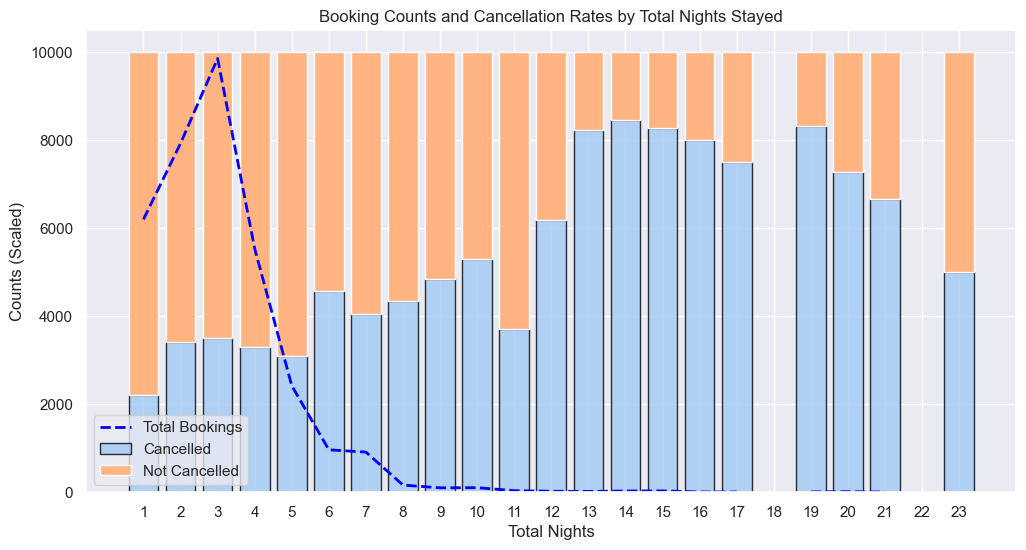

In [83]:
grouped_data = weekend.groupby(["total_nights", "booking_status"]).size().reset_index(name="count")
pivot_data = grouped_data.pivot(index="total_nights", columns="booking_status", values="count")
pivot_data["Total"] = pivot_data["Canceled"] + pivot_data["Not_Canceled"]

pivot_data["Canceled_scaled"] = pivot_data["Canceled"] * 10000 / pivot_data["Total"]
pivot_data["Not_Canceled_scaled"] = pivot_data["Not_Canceled"] * 10000 / pivot_data["Total"]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(pivot_data.index, pivot_data["Canceled_scaled"], label="Cancelled", alpha=0.8, edgecolor='black', linewidth=1)
ax.bar(pivot_data.index, pivot_data["Not_Canceled_scaled"], bottom=pivot_data["Canceled_scaled"], label="Not Cancelled")
ax.plot(pivot_data.index, pivot_data["Total"], color="blue", linewidth=2, linestyle='--', label="Total Bookings", )

ax.set_xlabel("Total Nights")
ax.set_ylabel("Counts (Scaled)")
ax.set_title("Booking Counts and Cancellation Rates by Total Nights Stayed")
ax.set_xticks(range(1,24))
ax.legend()
plt.show()

# Bars are the cancellation rates, (whole bar you can see as 100%)
# Numbers on the y axis are for the total bookings

- Conclusion : While there are fewer bookings for longer stays, they are more likely to be cancelled compared to shorter stays according to our data.
- ### Suggestion : Keep promoting & rewarding short stays as part of marketing strategy, as this is where the volume is. 
- Goal can be set as highest volume to have least cancellations. For example: 5% cashback on 1-4 night bookings if it s not canceled. Information upfront, cashback afterwards. 

## Before we finish let's also have a look at year, month and day columns.

#### Year

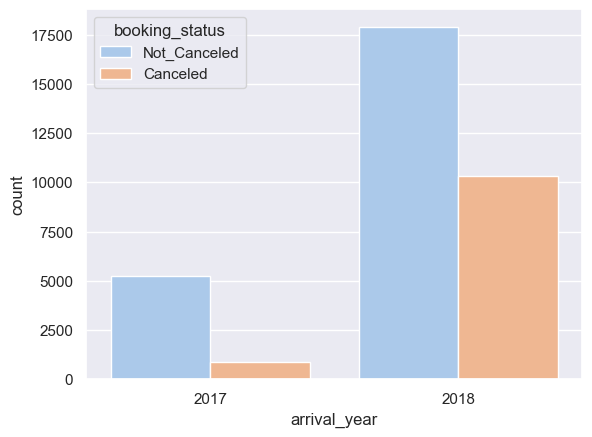

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x="arrival_year", hue="booking_status", data=data_clean)
plt.show()

Together with total bookings, the cancellation rate also increases from 2017 to 2018.

In [85]:
i = data_clean[data_clean.arrival_year == 2017]["booking_status"].value_counts()
print(f"2017 = {i[1]/i.sum()*100:.2f} %\n\n{i}")

2017 = 14.54 %

Not_Canceled    5226
Canceled         889
Name: booking_status, dtype: int64


In [86]:
j = data_clean[data_clean.arrival_year == 2018]["booking_status"].value_counts()
print(f"2017 = {j[1]/j.sum()*100:.2f} %\n\n{j}")

2017 = 36.57 %

Not_Canceled    17903
Canceled        10321
Name: booking_status, dtype: int64


#### Month

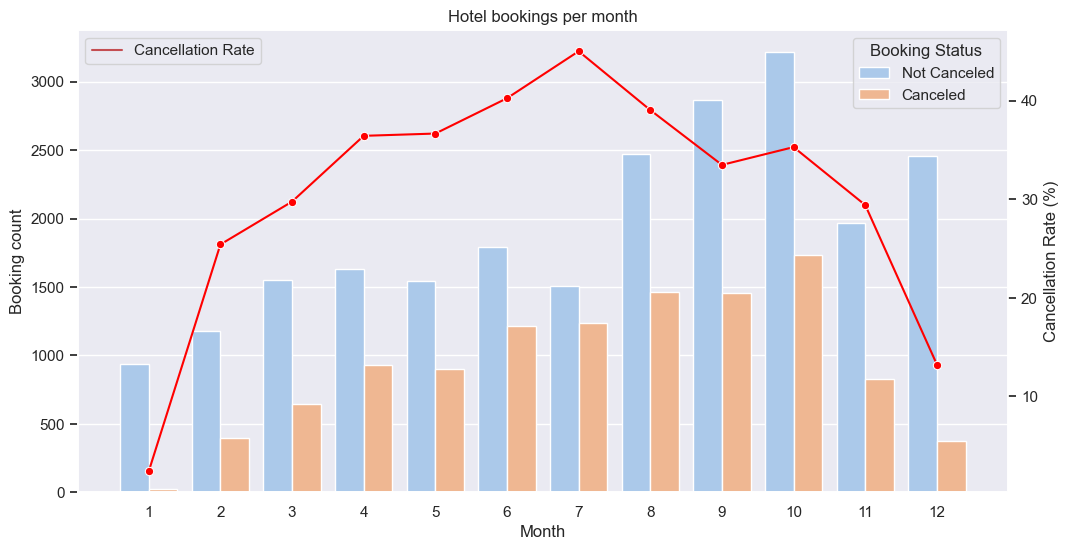

In [87]:
plt.figure(figsize=(12,6))

ax = sns.countplot(x="arrival_month", hue="booking_status", data=data_clean)
ax.set(title="Hotel bookings per month", xlabel="Month", ylabel="Booking count")
ax.legend(title="Booking Status", labels=["Not Canceled", "Canceled"])

cancel_rates = hotels[hotels["booking_status"] == "Canceled"].groupby("arrival_month").size() / hotels.groupby("arrival_month").size() * 100

ax2 = ax.twinx()

sns.lineplot(x=cancel_rates.index-1, y=cancel_rates.values, color="red", ax=ax2, marker='o')
ax2.set(ylabel="Cancellation Rate (%)")
ax2.legend(labels=["Cancellation Rate"], loc="upper center")

plt.plot([], [], 'r', label="Cancellation Rate")
plt.legend(loc="upper left")
plt.grid()
plt.show()

The months of December and January typically have the lowest cancellation rates, while there is a higher peak of cancellations in July. Further analysis is required to fully understand this trend, including factors such as the location of the hotel and information about the customers.

### Day

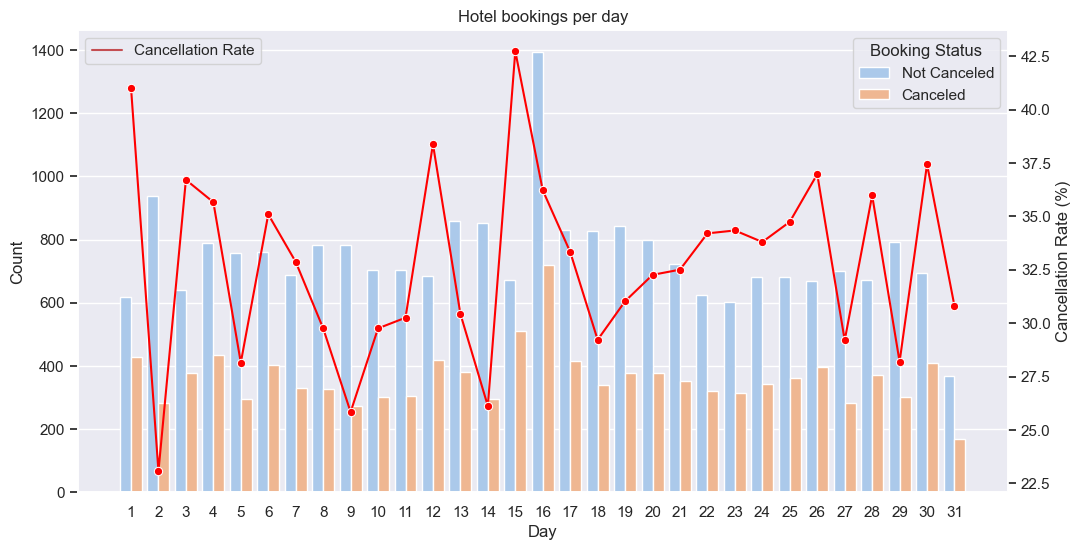

In [88]:
cancel_rates = hotels[hotels["booking_status"] == "Canceled"].groupby("arrival_date").size() / hotels.groupby("arrival_date").size() * 100

plt.figure(figsize=(12,6))

ax = sns.countplot(x="arrival_date", hue="booking_status", data=data_clean)
ax.set(title="Hotel bookings per day", xlabel="Day", ylabel="Count")
ax.legend(title="Booking Status", labels=["Not Canceled", "Canceled"])

ax2 = ax.twinx()
ax2.set(ylabel="Cancellation Rate (%)")
ax2.legend(labels=["Cancellation Rate"], loc="upper center")

sns.lineplot(x=cancel_rates.index-1, y=cancel_rates.values, color="red", ax=ax2, marker='o')

plt.plot([], [], 'r', label="Cancellation Rate")
plt.legend(loc="upper left")
plt.grid()
plt.show()

On average, the first day and the 15th day of the month tend to have the highest cancellation rates. Although this pattern could be linked to customer payment cycles, it is challenging to make a conclusive statement without further information about the customer base. It is important to note that these are booking dates, and not necessarily payment dates. Customers may have various payment options available to them, such as paying upfront or later.

# CONCLUSION

# Discoveries:

- The lead time(the time between booking and arrival in days), is the most significant factor in predicting cancellations.
- Cancellations aren't more likely during weekends.
- The duration of stay also plays a role, with longer stays being more likely (%54.5) to be cancelled than the shorter ones (%32.3).
- Some months have higher cancellation rates than others, indicating potential seasonality in cancellation patterns.
- Customers with special requests tend to cancel their order less, compared to the customers without special requests.
- Bookings with average price 100 dollars and higher per day are more likely to be cancelled than the orders with average price less than 100 dollars per day.

# Recommendations:

- Promote and reward last-minute / less-lead time bookings.
- Automated reminders (motivating upcoming vacation) for the customers who has bookings with longer lead times. 
- Promote and reward shorter stays as part of the hotel's marketing strategy, as shorter stays have lower cancellation rates.
- Offer incentives such as cashback on 1-4 night bookings if they are not cancelled to encourage guests to book shorter stays. (information upfront, cashback afterwards)
- If customers with high lead times are finding better deals elsewhere, consider offering a discount during the cancellation process based on current prices to incentivize them to stay.
- Further analysis suggests that providing discounts for longer bookings based on average daily prices for more expensive stays may positively impact customer behavior. Testing this approach is worth considering.
- Our analysis reveals that customers with special requests tend to cancel their bookings less. It would be interesting to investigate whether fulfilling their requests at the booking stage leads to higher customer satisfaction and subsequently lower cancellation rates compared to those without special requests.

# Potential next actions:

- Analyze and address the potential seasonality in cancellation patterns to develop targeted strategies for those months with higher cancellation rates. 
- Based on the provided booking information of the customer, it would be possible to use supervised learning techniques or to utilize neural networks for increased accuracy, to be able to make predictions directly and develop a customized strategy for each customer right after they book their stay.

![hotel cancellation banner](https://abovethelaw.com/wp-content/uploads/2015/06/thank-you-beach-sand.jpg)

## About Me
My name is Nurtan Bilmis and I am a Data Science & A.I. Enthusiast. I am currently enrolled in a Data Science & A.I. retraining program at The Hague University, where I am building my skills and knowledge in the field.

I am passionate about leveraging data to drive innovation and solve problems. I am a quick learner and enjoy continually improving my skills and knowledge. I am eager to apply my skills in a professional setting and actively seeking opportunities to contribute to projects and collaborate with other data professionals.

I will be available for job offers starting May 1st, 2023. If you have any questions, suggestions or would like to discuss potential opportunities, please feel free to reach out to me.

#### You can connect with me on LinkedIn: [My LinkedIn Profile](https://www.linkedin.com/in/nurtan-bilmis-767ba326a/)
#### Github repositories(work in progress) at: [My GitHub Profile](https://github.com/nurtanbilmis)